# Clasificación con redes neuronales convolucionales - Optimizacion del modelo


In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Resolviendo un problema de clasificacion

A lo largo de esta sección repasaremos los conceptos de CNNs aprendidos hasta el momento, creando una red neuronal capas de clasificar entre 10 diferentes tipos de clases. Para ello vamos a utilizar el dataset [CIFAR10](https://keras.io/api/datasets/cifar10/) el cual consta de 50,000 imágenes de 32x32 píxeles a color, para el training set y 10,000 imágenes con las mismas características para el conjunto de pruebas.

Las clases disponibles son:

| Label |  Description   |
| :---: | :------------: |
|   0   |  **Airplane**  |
|   1   | **Automobile** |
|   2   |    **Bird**    |
|   3   |    **Cat**     |
|   4   |    **Deer**    |
|   5   |    **Dog**     |
|   6   |    **Frog**    |
|   7   |   **Horse**    |
|   8   |    **Ship**    |
|   9   |   **Truck**    |


## 1. importamos bibliotecas necesarias:


In [5]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers
from keras.datasets import cifar10
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

Nuevas bibliotecas de este ejemplo


In [6]:
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
from os.path import exists

Definimos nuestra función auxiliar para gráficar resultados:


In [7]:
def plot_result(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]
    epoch = range(1, len(loss_values) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    fig.suptitle(f"Neural Network's Result")
    ax[0].set_title("Loss function over epochs")
    ax[0].set(ylabel="Loss", xlabel="Epochs")
    ax[0].plot(epoch, loss_values, "o-r", label="Training")
    ax[0].plot(epoch, val_loss_values, "--", label="Validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epochs")
    ax[1].set(ylabel=metric, xlabel="Epochs")
    ax[1].plot(epoch, metric_values, "o-r", label="Training")
    ax[1].plot(epoch, val_metric_values, "--", label="Validation")
    ax[1].legend()

    plt.show()

## Descargamos el dataset CIFAR10


In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [9]:
print(f"x_train shape: {X_train.shape}")

x_train shape: (50000, 32, 32, 3)


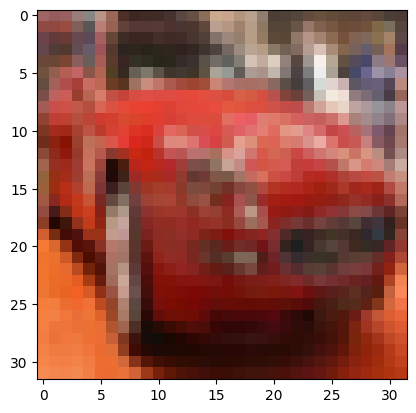

In [10]:
plt.imshow(X_train[5])

## 2: Limpiamos nuestros datos

Como ya sabemos, lo primero que debemos hacer es normalizar la escala de nuestros pixeles de 0-255 a 0-1


In [11]:
# X_train = X_train.astype("float32") / 255
# X_test = X_test.astype("float32") / 255

También sabemos que aunque NO es la única forma de trabajar para clasificación de multiples clases, es una estrategia convertir el label encoding en one hot encoding:


In [12]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## 3: Creando particiones de validación


In [13]:
# Creando nuevas particiones de los datos

(X_train, X_valid) = X_train[5000:], X_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print(f"x_train shape: {X_train.shape}")
print(f"{X_train.shape[0]} train samples\n")

print("train: ", X_train.shape[0])
print("val: ", X_valid.shape[0])
print("test: ", X_test.shape[0])

x_train shape: (45000, 32, 32, 3)
45000 train samples

train:  45000
val:  5000
test:  10000


Podemos observar como ahora contamos con 3 conjuntos de datos, para el set de entrenamiento tenemos 45,000 muestras, de las cuales cada una de ellas tiene una forma de `(32, 32, 3)`. Para el conjunto de validación tenemos **5,000 muestras**y para el conjunto de pruebas **10,000.**


## 4: Normalizando datos

Aquí es MUY IMPORTANTE tener en cuenta que estamos normalizando TODAS las particiones con los datos del dataset de entrenamiento. Esto porque NOSOTROS NO debemos tener ningún tipo de información de los datos de validación o prueba. Esto puede afectar los resultados finales, pero reflejan mucho mejor la realidad de predicción del modelo.


In [14]:
# normalizando los datos

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_valid = X_valid.astype("float32")

mean_train = np.mean(X_train)
std_train = np.std(X_train)

X_train = (X_train - mean_train) / (std_train + 1e-7)
X_test = (X_test - mean_train) / (std_train + 1e-7)
X_valid = (X_valid - mean_train) / (std_train + 1e-7)

## 5: Creamos nuestro aumentador de datos


In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

## 6: Creando nuestro callback de monitoreo de val accuracy


In [17]:
checkpoint_cb = ModelCheckpoint(
    filepath="../model/best_model_cifar.h5",
    verbose=1,
    save_best_only=True,
    monitor="val_accuracy",
)

## Creación de red convolucional para clasificación


### Definiendo la arquitectura del modelo

Para este paso es importante recordar:

- Debemos tener presente el shape de las imágenes del dataset.

- La cantidad de filtros aplicados en cada capa es arbitrario, pero generalmente conforme más profunda es la capa mayor cantidad de filtros

- La capa de `MaxPooling2D` sirve para reducir la complejidad del modelo, al ir reduciendo las dimensiones de la capa.

- Utilizar una capa de `DropOut` es una buena idea para reducir el posible overfitting que puede presentar el modelo.

- La arquitectura propuesta a continuación NO es una receta de cocina y NO tiene por qué ser la mejor para todos los escenarios, es simplemente una propuesta que sigue la arquitectura básica de cualquier CNN vista en [Arquitectura de una CNN](https://github.com/ichcanziho/Deep_Learnining_Platzi/tree/master/2%20Curso%20de%20Redes%20Neuronales%20Convolucionales)


**DEFINIMOS la arquitectura de nuestra CNN**

La principal diferencia respecto a la versión original es que aquí estamos añadiendo `BatchNormalization()` a la salida de cada capa de `Activation()`


In [20]:
def architecture(
    base_filtros: int, w_regularized: float, shape: tuple, num_classes: int
):
    """
    Definiendo la arquitectura de nuestra CNN
    :param base_filtros: Número de filtros que tomara como base la CNN (capas posteriores usaran multiplos de este número)
    :param w_regularized: Peso para utilizar por el regularizador L2
    :param shape: forma del tensor de entrada (dimensiones de las imágenes de entrenamiento)
    :param num_classes: número de clases a clasificar por la CNN
    :return: modelo de CNN
    """

    model = Sequential()

    # CONV1
    model.add(
        Conv2D(
            filters=base_filtros,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
            input_shape=shape,
        )
    )

    model.add(Activation("relu"))
    # BatchNormalization
    model.add(BatchNormalization())

    # CONV2
    model.add(
        Conv2D(
            filters=base_filtros,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )

    model.add(Activation("relu"))
    # BatchNormalization
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # CONV3

    model.add(
        Conv2D(
            filters=base_filtros * 2,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # ConV4
    model.add(
        Conv2D(
            filters=base_filtros * 2,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # CONV5
    model.add(
        Conv2D(
            filters=base_filtros * 4,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    # CONV6
    model.add(
        Conv2D(
            filters=base_filtros * 4,
            kernel_size=(3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(w_regularized),
        )
    )
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Capa de clasificación
    model.add(Dense(units=num_classes, activation="softmax"))
    print(model.summary())

    return model

### Entrenamiento de nuestro modelo de clasificación optimizado


Aquí vamos a agregar una pequeña línea que nos permitirá entrenar el modelo por primera vez, o en caso de que ya éxista el modelo, lo puede cargar para continuar con su proceso de entrenamiento posterior.


In [21]:
if not exists("../model/best_model_cifar.h5"):
    print("Entrenando modelo por primera vez")
    print("*" * 64)
    print("Creando arquitectura de la red")
    md = architecture(
        base_filtros=32,
        w_regularized=1e-4,
        shape=X_train[0].shape,
        num_classes=num_classes,
    )

Entrenando modelo por primera vez
****************************************************************
Creando arquitectura de la red


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                        

## 7: Compilando y entrenando el modelo

Como pequeña variante al código original aquí vamos a utilizar `Adam()` como optimizador en lugar del que siempre hemos usado rmsprop


In [22]:
print("Empezando entrenamiento")

md.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics="accuracy")

Empezando entrenamiento


In [23]:
history = md.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    callbacks=[checkpoint_cb],
    steps_per_epoch=X_train.shape[0] // 128,
    epochs=20,
    verbose=2,
    validation_data=(X_valid, y_valid),
)

Epoch 1/20



Epoch 1: val_accuracy improved from -inf to 0.33260, saving model to ../model\best_model_cifar.h5
351/351 - 34s - loss: 2.2082 - accuracy: 0.3318 - val_loss: 1.9924 - val_accuracy: 0.3326 - 34s/epoch - 98ms/step
Epoch 2/20


c:\Users\mike\Desktop\redes_convolucionales\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.33260 to 0.47300, saving model to ../model\best_model_cifar.h5
351/351 - 33s - loss: 1.6990 - accuracy: 0.4444 - val_loss: 1.6390 - val_accuracy: 0.4730 - 33s/epoch - 93ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.47300 to 0.55800, saving model to ../model\best_model_cifar.h5
351/351 - 32s - loss: 1.4887 - accuracy: 0.5134 - val_loss: 1.4056 - val_accuracy: 0.5580 - 32s/epoch - 91ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.55800 to 0.59240, saving model to ../model\best_model_cifar.h5
351/351 - 32s - loss: 1.3639 - accuracy: 0.5590 - val_loss: 1.2424 - val_accuracy: 0.5924 - 32s/epoch - 90ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.59240
351/351 - 32s - loss: 1.2579 - accuracy: 0.5878 - val_loss: 1.3931 - val_accuracy: 0.5732 - 32s/epoch - 90ms/step
Epoch 6/20

Epoch 6: val_accuracy improved from 0.59240 to 0.66040, saving model to ../model\best_model_cifar.h5
351/351 - 32s - loss: 1.1694 - accuracy:

#### Análisis de resultados


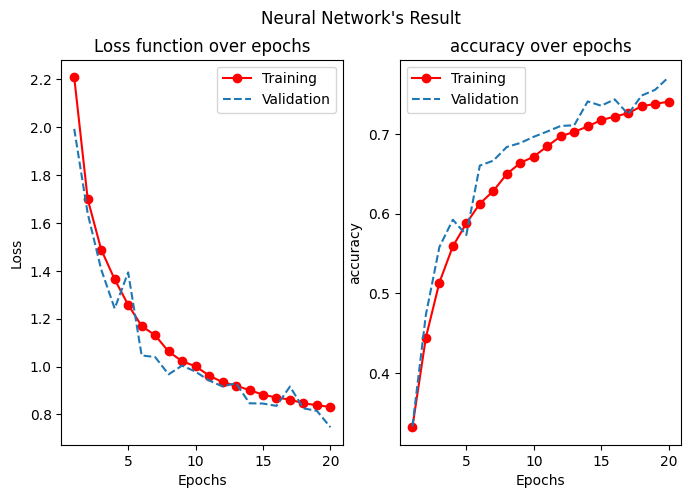

313/313 [==============================] - 2s 8ms/step - loss: 0.7823 - accuracy: 0.7681


[0.7822822332382202, 0.7681000232696533]

In [24]:
plot_result(history, "accuracy")
md.evaluate(X_test, y_test)

Podemos observar que en el mismo número de iteraciones, en general el primer modelo obtiene mejores resultados, pero observamos una mayor diferencia entre los resultados de training y validation, indicando que el primer modelo es más cercano a presentar overfitting en contraste al segundo modelo que a pesar de no presentar una mejora circunstancial, sí ha mostrado un comportamiento más cercano al set de entrenamiento.

Ahora como ya tenemos un modelo guardado, podemos cargarlo y seguir entrenando un par de iteraciones más:


## 8: Retomando entrenamiento


In [25]:
print("Abriendo modelo y continuando entrenamiento")

md = load_model("../model/best_model_cifar.h5")

history = md.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    callbacks=[checkpoint_cb],
    steps_per_epoch=X_train.shape[0] // 128,
    epochs=10,
    verbose=2,
    validation_data=(X_valid, y_valid),
)

Abriendo modelo y continuando entrenamiento
Epoch 1/10

Epoch 1: val_accuracy did not improve from 0.77140
351/351 - 35s - loss: 0.8204 - accuracy: 0.7459 - val_loss: 0.7912 - val_accuracy: 0.7568 - 35s/epoch - 99ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.77140
351/351 - 34s - loss: 0.8186 - accuracy: 0.7479 - val_loss: 0.7755 - val_accuracy: 0.7712 - 34s/epoch - 96ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.77140
351/351 - 33s - loss: 0.8100 - accuracy: 0.7518 - val_loss: 0.8047 - val_accuracy: 0.7602 - 33s/epoch - 93ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.77140
351/351 - 33s - loss: 0.8069 - accuracy: 0.7529 - val_loss: 0.8422 - val_accuracy: 0.7554 - 33s/epoch - 94ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.77140 to 0.78400, saving model to ../model\best_model_cifar.h5
351/351 - 34s - loss: 0.8025 - accuracy: 0.7557 - val_loss: 0.7333 - val_accuracy: 0.7840 - 34s/epoch - 96ms/step
Epoch 6/10


c:\Users\mike\Desktop\redes_convolucionales\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: val_accuracy did not improve from 0.78400
351/351 - 33s - loss: 0.7917 - accuracy: 0.7597 - val_loss: 0.8006 - val_accuracy: 0.7668 - 33s/epoch - 93ms/step
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.78400
351/351 - 33s - loss: 0.7906 - accuracy: 0.7625 - val_loss: 0.8065 - val_accuracy: 0.7636 - 33s/epoch - 94ms/step
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.78400
351/351 - 33s - loss: 0.7849 - accuracy: 0.7638 - val_loss: 0.8451 - val_accuracy: 0.7502 - 33s/epoch - 93ms/step
Epoch 9/10

Epoch 9: val_accuracy did not improve from 0.78400
351/351 - 33s - loss: 0.7844 - accuracy: 0.7639 - val_loss: 0.7780 - val_accuracy: 0.7728 - 33s/epoch - 94ms/step
Epoch 10/10

Epoch 10: val_accuracy improved from 0.78400 to 0.78460, saving model to ../model\best_model_cifar.h5
351/351 - 33s - loss: 0.7733 - accuracy: 0.7698 - val_loss: 0.7528 - val_accuracy: 0.7846 - 33s/epoch - 94ms/step


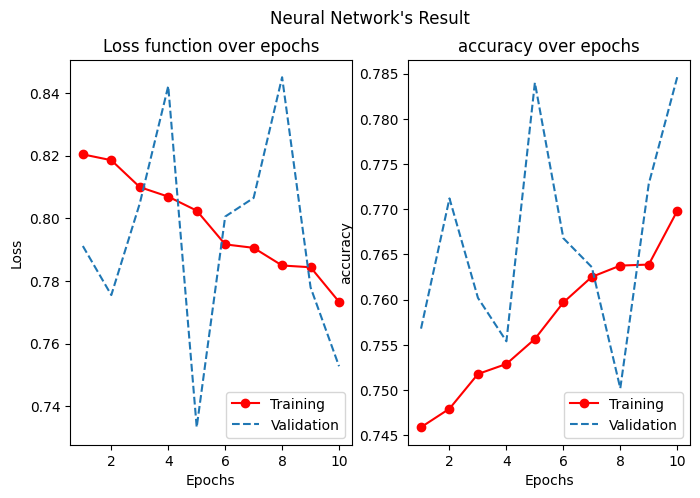

In [26]:
plot_result(history, "accuracy")

## 9: Resultados finales:


In [27]:
acc = md.evaluate(X_test, y_test)
print("Normal Accuracy: ", acc)

best_model = load_model("../model/best_model_cifar.h5")

acc = best_model.evaluate(X_test, y_test)

print("Loaded Model acc: ", acc)

313/313 [==============================] - 3s 9ms/step - loss: 0.7928 - accuracy: 0.7713
Normal Accuracy:  [0.7927998900413513, 0.7713000178337097]
313/313 [==============================] - 3s 9ms/step - loss: 0.7928 - accuracy: 0.7713
Loaded Model acc:  [0.7927998900413513, 0.7713000178337097]


## Conclusiones

Este mini proyecto nos ha servido para condensar MUCHÍSIMOS temas vistos hasta el momento:

- Data generation

- Data

- Callbacks

- Arquitectura de una CNN

- Guardado de CNN models

- Restableciendo una CNN para seguir entrenando.

El primer modelo obtenido parece haber tenido un mejor resultado, esto nos demuestra que no hay una fórmula secreta para mejorar los resultados obtenidos y que a veces menos es más. Sin embargo, lo más importante es tener conocer una metodología correcta y profunda de diferentes herramientas de deep learning. Es nuestra responsabilidad como científicos de datos encontrar diferentes combinaciones más complejas o sencillas que nos permitan optimizar nuestros problemas de clasificación.
